# Stochastic Swim Meet Simulator

In this notebook, I attempt to build a probabilistic simulator for the Missouri Boys High School State 2025 Swimming Championships using a **Markov-ish performance state** model & **Monte Carlo** simulation.

Here is my process:
1) Load in CSV data & formatting properly
2) Create variability in every swimmer's performance using a simple Markov performance state
3) Adaptive interdependence, where if one person on the team does good, the rest also do better (team momentum effect)
4) Do the Monte Carlo loop to estimate each team's win probabilities and distributions
5) Integer linear programming to optimize events for swimmer (2 individual events per swimmer, will add relay stuff later)

Summary: (1) Markov chain for each swimmer &rarr; (2) Monte Carlo sampling across many simulated meets &rarr; (3) Resulting outcome distribution


In [207]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt

import pulp

## 1) Load & prep data

Input CSV format (downloaded from the MSHSAA website):
- Empty column headers, except for event names
- Then columns have place, time, competitor name, school name which repeats horizontally

Output CSV format:
- `name`: swimmer name
- `team`: school name
- `event`: event name, (relays not done yet)
- `best_time`: best seed time in seconds this season
- `seed_rank`: rank/seed for that event (1 = top seed)

In [208]:
df = pd.read_csv('Girls Swimming Export.csv', header=None)

# Extract event names from first row (skip empty columns)
events = []
event_cols = []
for i in range(0, len(df.columns)-1):
    if i < len(df.columns) and pd.notna(df.iloc[0, i+1]):
        event_name = df.iloc[0, i+1]
        events.append(event_name)
        event_cols.append(i)

In [209]:
events

['200 Medley Relay',
 '200 Freestyle',
 '200 Individual Medley',
 '50 Freestyle',
 '100 Butterfly',
 '100 Freestyle',
 '500 Freestyle',
 '200 Freestyle Relay',
 '100 Backstroke',
 '100 Breaststroke',
 '400 Freestyle Relay']

In [210]:
# Initialize list to store all swimmer records
all_records = []

# Process each event
for event_idx, (event_name, col_start) in enumerate(tqdm(zip(events, event_cols), total=len(events), desc="Processing Events")):
    # Determine if this is a relay event (check if there are swimmer names)
    is_relay = 'Relay' in event_name
    
    # Process each row (starting from row 1, skipping header row 0)
    for row_idx in tqdm(range(1, len(df)), leave=False, desc=f"Event {event_name}"):
        rank = df.iloc[row_idx, col_start - 1]
        time = df.iloc[row_idx, col_start]
        name_or_team = df.iloc[row_idx, col_start + 1]
        team = df.iloc[row_idx, col_start + 2] if not is_relay else name_or_team  # For relays, name_or_team is the team name
        
        # Skip if rank or time is missing
        if pd.isna(rank) or pd.isna(time) or pd.isna(name_or_team):
            continue
        
        # Convert time from MM:SS.SS to total seconds
        if isinstance(time, str) and ':' in time:
            parts = time.split(':')
            total_seconds = float(parts[0]) * 60 + float(parts[1])
        else:
            total_seconds = float(time)
        
        # For individual events
        if not is_relay:
            record = {
                'name': name_or_team,
                'team': team,
                'event': event_name,
                'best_time': total_seconds,
                'seed_rank': int(rank),
                'is_relay': False
            }
            all_records.append(record)
        else:
            # For relay events: team-based, not individual swimmer-based
            record = {
                'name': team,  # For relays, 'name' is the team name
                'team': team,
                'event': event_name,
                'best_time': total_seconds,
                'seed_rank': int(rank),
                'is_relay': True
            }
            all_records.append(record)

# Create DataFrame from records
result_df = pd.DataFrame(all_records)

Processing Events: 100%|██████████| 11/11 [00:00<00:00, 96.06it/s]


In [211]:
result_df.sample(5)

,name,team,event,best_time,seed_rank,is_relay
996,Olivia Manning,Carthage,100 Breaststroke,70.55,17,False
592,Anna Eshleman,Raymore-Peculiar,100 Freestyle,56.69,33,False
989,Molly Moriarty,Visitation Academy,100 Breaststroke,69.49,10,False
1080,Kennedy Roberts,Notre Dame de Sion,100 Breaststroke,78.19,101,False
41,Cor Jesu Academy,Cor Jesu Academy,200 Medley Relay,122.74,42,True


In [212]:
# save results
result_df.to_csv('swimmers.csv', index=False)

In [213]:
# split by class
swimmers = pd.read_csv("swimming_performance.csv")
# swimmers = pd.read_csv("swimmers.csv")
schools = pd.read_csv("schools.csv")

# Merge Class info into swimmer table
swimmers = swimmers.merge(
    schools[['School', 'Class']],
    left_on='team',
    right_on='School',
    how='left',
    validate='m:1'
).drop(columns=['School'])

In [214]:
swimmers.sample(5)

,name,team,event,best_time,seed_rank,is_relay,Class
801,Jia Hurst,Park Hill South,500 Free,5:58.99,63,False,2
566,Adrianna Hudnall,Liberty North,100 Free,53.49,5,False,2
508,Delaney Mehl,Liberty,100 Fly,1:04.63,26,False,2
493,Sarah Lamb,Principia,100 Fly,1:03.07,19,False,1
732,Evyn Lashley,Eureka,500 Free,5:37.67,22,False,2


In [215]:
# Now assign new seed ranks within each class+event group
swimmers["seed_rank"] = (
    swimmers.groupby(["Class", "event"])
    .cumcount() + 1
)

# Save or inspect
swimmers.to_csv("swimmers_reseeded.csv", index=False)

In [216]:
def convert_swim_time(time_str):
    """
    Convert swimming time string to decimal seconds and return as float.
    Also provides a string representation in consistent format.
    """
    if pd.isna(time_str) or not isinstance(time_str, str):
        return np.nan, ""
    
    time_str = time_str.strip()
    if not time_str:
        return np.nan, ""
    
    try:
        parts = time_str.split(':')
        
        if len(parts) == 1:
            # Format: "57.04"
            seconds = float(parts[0])
            # Format as MM:SS.mm if over 60 seconds
            if seconds >= 60:
                minutes = int(seconds // 60)
                remaining_seconds = seconds % 60
                formatted = f"{minutes}:{remaining_seconds:05.2f}"
            else:
                formatted = f"{seconds:.2f}"
            return seconds, formatted
        
        elif len(parts) == 2:
            # Format: "1:46.57"
            minutes = float(parts[0])
            seconds = float(parts[1])
            total_seconds = minutes * 60 + seconds
            
            # Format consistently
            if minutes > 0:
                formatted = f"{int(minutes)}:{seconds:05.2f}"
            else:
                formatted = f"{seconds:.2f}"
            
            return total_seconds, formatted
        
        elif len(parts) == 3:
            # Format: "1:02:34.56" - rare for high school swimming
            hours = float(parts[0])
            minutes = float(parts[1])
            seconds = float(parts[2])
            total_seconds = hours * 3600 + minutes * 60 + seconds
            
            # Format consistently
            if hours > 0:
                formatted = f"{int(hours)}:{int(minutes):02d}:{seconds:05.2f}"
            elif minutes > 0:
                formatted = f"{int(minutes)}:{seconds:05.2f}"
            else:
                formatted = f"{seconds:.2f}"
            
            return total_seconds, formatted
        
        else:
            return np.nan, time_str
            
    except (ValueError, AttributeError):
        return np.nan, time_str

# Function to apply to a DataFrame
def add_time_seconds_column(df, time_col='best_time'):
    """
    Add a column with time converted to decimal seconds.
    Also adds a formatted time column for consistency.
    """
    # Apply conversion function
    results = df[time_col].apply(lambda x: convert_swim_time(x) if pd.notna(x) else (np.nan, ""))
    
    # Extract seconds and formatted times
    df[time_col] = [result[0] for result in results]
    df['time_formatted'] = [result[1] for result in results]
    
    return df

In [217]:
add_time_seconds_column(swimmers)

,name,team,event,best_time,seed_rank,is_relay,Class,time_formatted
0,St. Joseph's Academy,St. Joseph's Academy,200 Medley Relay,106.57,1,True,2,1:46.57
1,Park Hill South,Park Hill South,200 Medley Relay,108.32,2,True,2,1:48.32
2,Rock Bridge,Rock Bridge,200 Medley Relay,108.68,3,True,2,1:48.68
3,Visitation Academy,Visitation Academy,200 Medley Relay,110.53,1,True,1,1:50.53
4,Westminster Christian Academy,Westminster Christian Academy,200 Medley Relay,112.21,4,True,2,1:52.21
...,...,...,...,...,...,...,...,...
1149,Logan-Rogersville,Logan-Rogersville,400 Free Relay,269.97,35,True,1,4:29.97
1150,Ozark,Ozark,400 Free Relay,270.52,32,True,2,4:30.52
1151,Kickapoo,Kickapoo,400 Free Relay,271.24,33,True,2,4:31.24
1152,Hannibal,Hannibal,400 Free Relay,271.98,36,True,1,4:31.98


In [218]:
# Sort by class, then event, then best_time ascending (faster = smaller time)
swimmers = swimmers.sort_values(
    ["Class", "event", "best_time"], ascending=[True, True, True])

In [219]:
class1_swimmers = swimmers[swimmers['Class'] == 1]
class2_swimmers = swimmers[swimmers['Class'] == 2]

In [220]:
result_df = class1_swimmers

In [221]:
result_df.head(10)

,name,team,event,best_time,seed_rank,is_relay,Class,time_formatted
893,Gracey MacLaughlin,Louisiana,100 Back,57.04,1,False,1,57.04
895,Madelyn Mug,Visitation Academy,100 Back,57.94,2,False,1,57.94
898,Ann Erwin,Webster Groves,100 Back,59.57,3,False,1,59.57
901,Charlotte Leary,Villa Duchesne,100 Back,60.93,4,False,1,1:00.93
902,Ella Paul,Rockwood Summit,100 Back,60.97,5,False,1,1:00.97
903,Jane Hill,Villa Duchesne,100 Back,61.10,6,False,1,1:01.10
904,Missy Mizell,Lebanon,100 Back,61.27,7,False,1,1:01.27
905,Polly Fendler,St. Teresa's Academy,100 Back,61.65,8,False,1,1:01.65
906,Olivia Deberge,Timberland,100 Back,61.74,9,False,1,1:01.74
907,Olive Agustin,Clayton,100 Back,61.77,10,False,1,1:01.77


## 2) Performance model (w/ MCMC!)
I model each swimmer's resulting time using Markov Chain Monte Carlo (MCMC). This best simulates how a swimmer might perform at a specific meet because each swimmer has a performance state *(Good / Average / Bad)* and I add noise of +/- 0.5% or ~0.2s to every outcome.

**To explain the Markov Chain part more:** Swimmers move between these states in their events as the simulated swim meet goes on.
| State   | Time Adjustment      |
| ------- | -------------------- |
| Good    | 0.98 × personal best |
| Average | 1.00 × personal best |
| Bad     | 1.03 × personal best |

These are the transition probabilities of moving between states:
| From → To   | Good | Average | Bad |
| ----------- | ---- | ------- | --- |
| **Good**    | 0.7  | 0.2     | 0.1 |
| **Average** | 0.3  | 0.5     | 0.2 |
| **Bad**     | 0.1  | 0.3     | 0.6 |

Ex. If a swimmer is in the Good state right now, they have:
- a 70% chance to stay Good in the next event,
- a 20% chance to slip to Average,
- a 10% chance to have a Bad race.

Note how it's stochastic, meaning that you don't know the exact outcome but you know the distribution. This is to capture the concept of a swimmer having a 'good' or 'bad' day or race and how that affects other events

**To explain the Monte Carlo part more:** each meet = 1 Monte Carlo trial & a swimmer's performance state will be tested for each meet as well. Each swimmer's time is a random draw from a normal distribution that's centered around their performance state at that time, which should add +/- 0.5% or ~0.2s variability. I will also run the simulation thousands of times to sample it again and again to get a representation of the probabilities & chains.

In [222]:
PERF_STATES = ['Good','Average','Bad']

transition_matrix = {
    'Good': {'Good':0.7,'Average':0.25,'Bad':0.05},
    'Average': {'Good':0.15,'Average':0.7,'Bad':0.15},
    'Bad': {'Good':0.05,'Average':0.25,'Bad':0.7}
}

sigma_mult = {'Good':0.005, 'Average':0.01, 'Bad':0.02}

In [223]:
def step_state(current_state):
    probs = list(transition_matrix[current_state].values())
    next_state = np.random.choice(list(transition_matrix[current_state].keys()), p=probs)
    return next_state

def sample_time(best_time, state):
    sigma = best_time * sigma_mult[state]
    return np.random.normal(best_time, sigma)


## 3) Adaptive interdependence (team momentum)

I also added a simple **team momentum** effect, which is where if earlier events produce unexpectedly good results for a team, later swimmers from the same team also have a small time improvement. This was pretty simple and I can add more sophistication later (fatigue, lane number effects, head-to-head racing, etc.)

In [224]:
def apply_team_momentum(team_scores_by_event, base_time, team, momentum_factor=0.001):
    # team_scores_by_event: dict tracking cumulative unexpected_points (or performance) per team so far
    # base_time: best_time
    # momentum_factor: seconds improvement per unit of team momentum
    momentum = team_scores_by_event.get(team, 0.0)
    adjusted_time = base_time - (momentum * momentum_factor)
    return adjusted_time

## 4) Event Optimization via ILP

For each simulated performance dataset, I use PuLP for Integer Linear Programming to assign swimmers to at most 2 events to optimize total team points. Each Monte Carlo trial givesslightly different “optimal meet lineup” based on simulated performances.

Objective: maximize total expected team points. but expected points are non-linear (depends on relative entries), so ILP needs approximations (use predicted expected points)

Binary variable x[swimmer, event] = 1 if swimmer enters that event

Constraints:
- sum(x[swimmer, event]) <= 2
- exactly 16 swimmers per event (or whatever format)

Formulate as integer program where decision variables
- Relay-specific constraints (exactly 4 per relay lineup).
- Event entry limits (e.g., max 2 swimmers per team per event if applicable).

In [225]:
POINTS = [20,17,16,15,14,13,12,11,9,7,6,5,4,3,2,1]

def seed_to_points(rank):
    if rank <= 16:
        return POINTS[rank-1]
    else:
        return max(0.5, 10 / rank)

def optimize_event_assignments(df, max_events_per_swimmer=2, swimmers_per_event=16):
    df = df.copy()
    df["expected_points"] = df["seed_rank"].apply(seed_to_points)
    
    swimmers = df["name"].unique()
    events = df["event"].unique()
    
    # Define model
    model = pulp.LpProblem("SwimMeetOptimization", pulp.LpMaximize)
    
    # Decision variables
    x = pulp.LpVariable.dicts(
        "x",
        ((r["name"], r["event"]) for _, r in df.iterrows()),
        cat="Binary"
    )
    
    # Objective: maximize expected points
    model += pulp.lpSum([
        r["expected_points"] * x[(r["name"], r["event"])] for _, r in df.iterrows()
    ])
    
    # Constraint: each swimmer ≤ 2 events
    for s in swimmers:
        model += pulp.lpSum([
            x[(r["name"], r["event"])] for _, r in df[df["name"] == s].iterrows()
        ]) <= max_events_per_swimmer
    
    # Constraint: each event has 16 swimmers if possible
    for e in events:
        event_swimmers = df[df["event"] == e]
        if len(event_swimmers) >= swimmers_per_event:
            model += pulp.lpSum([
                x[(r["name"], e)] for _, r in event_swimmers.iterrows()
            ]) == swimmers_per_event
        else:
            model += pulp.lpSum([
                x[(r["name"], e)] for _, r in event_swimmers.iterrows()
            ]) <= len(event_swimmers)
    
    # Mutually exclusive event pairs
    conflict_pairs = [
        ("200 Freestyle", "200 IM"),
        ("50 Freestyle", "200 IM"),
        ("100 Freestyle", "100 Butterfly"),
        ("100 Backstroke", "100 Breaststroke"),
        ("500 Freestyle", "100 Freestyle"),
    ]
    
    for s in swimmers:
        swimmer_events = df[df["name"] == s]["event"].unique()
        for e1, e2 in conflict_pairs:
            if e1 in swimmer_events and e2 in swimmer_events:
                model += x[(s, e1)] + x[(s, e2)] <= 1
    
    # Solve
    model.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Collect chosen
    selected_rows = []
    for _, r in df.iterrows():
        if pulp.value(x[(r["name"], r["event"])]) > 0.5:
            selected_rows.append(r)
    selected = pd.DataFrame(selected_rows)
    
    # Reseed
    selected["new_seed_rank"] = (
        selected.groupby("event")["best_time"].rank("dense").astype(int)
    )
    selected = selected.sort_values(["event", "new_seed_rank"]).reset_index(drop=True)
    
    return selected

In [226]:
output = optimize_event_assignments(class1_swimmers)
output.to_csv("class1_assignments.csv")

## 4) Scoring and running a single simulated meet

I score the meet using top 16 scoring points: [20,17,16,15,14,13,12,11,9,7,6,5,4,3,2,1]. I'll add Relay functionality later

In [227]:
POINTS = [20,17,16,15,14,13,12,11,9,7,6,5,4,3,2,1]  # assign to places 1..16

def simulate_one_meet(df, assignments, relay_assignments=None, verbose=False):
    # df: DataFrame rows: name, team, event, best_time, is_relay
    # assignments: dict mapping swimmer -> list of events they're entered (enforces <=2 events)
    # relay_assignments: dict mapping team -> list of relay events they're entered in
    # returns: dataframe of results and team scores
    
    # initialize states for each swimmer randomly (or all Average)
    swimmer_states = {name: np.random.choice(PERF_STATES, p=[0.2,0.6,0.2]) for name in df[df['is_relay']==False]['name'].unique()}
    
    # For relays, use team-based states
    team_relay_states = {team: np.random.choice(PERF_STATES, p=[0.2,0.6,0.2]) for team in df[df['is_relay']==True]['team'].unique()}
    
    results = []
    # track team 'unexpectedness' as sum of (expected_rank - actual_rank) positive values
    team_momentum = {}
    
    # simulate per event in a deterministic order (you can randomize event order to capture ordering effects)
    events_order = df['event'].unique().tolist()
    for event in events_order:
        # Check if this is a relay event
        event_rows = df[df['event'] == event]
        is_relay = event_rows['is_relay'].iloc[0] if len(event_rows) > 0 else False
        
        if is_relay:
            # Handle relay events (team-based)
            if relay_assignments is None:
                # If no relay assignments provided, use all teams that have this relay in df
                entrants = event_rows['team'].unique().tolist()
            else:
                # Use relay assignments
                entrants = [team for team, evs in relay_assignments.items() if event in evs]
            
            rows = df[df['team'].isin(entrants) & (df['event']==event)]
            
            sim_rows = []
            for _, r in rows.iterrows():
                team = r['team']; base = r['best_time']
                # step state for team relay performance
                cur_state = team_relay_states.get(team, 'Average')
                next_state = step_state(cur_state)
                team_relay_states[team] = next_state
                # apply team momentum to base time
                adj_base = apply_team_momentum(team_momentum, base, team)
                time = sample_time(adj_base, next_state)
                sim_rows.append({'name':team,'team':team,'event':event,'time':time,'state':next_state,'is_relay':True})
        else:
            # Handle individual events
            entrants = [s for s, evs in assignments.items() if event in evs]
            rows = df[df['name'].isin(entrants) & (df['event']==event)]
            
            sim_rows = []
            for _, r in rows.iterrows():
                name = r['name']; team = r['team']; base = r['best_time']
                # step state to model carryover between events for the swimmer
                cur_state = swimmer_states.get(name, 'Average')
                next_state = step_state(cur_state)
                swimmer_states[name] = next_state
                # apply team momentum to base time
                adj_base = apply_team_momentum(team_momentum, base, team)
                time = sample_time(adj_base, next_state)
                sim_rows.append({'name':name,'team':team,'event':event,'time':time,'state':next_state,'is_relay':False})
        
        # rank by time and assign points
        if not sim_rows:
            continue
        sim_df = pd.DataFrame(sim_rows).sort_values('time').reset_index(drop=True)
        sim_df['place'] = sim_df.index + 1
        
        # Relays get DOUBLE points
        if is_relay:
            sim_df['points'] = sim_df['place'].apply(lambda p: POINTS[p-1] * 2 if p<=len(POINTS) else 0)
        else:
            sim_df['points'] = sim_df['place'].apply(lambda p: POINTS[p-1] if p<=len(POINTS) else 0)
        
        # update team momentum: if a swimmer/team beats expectation (seed_rank) by a margin, increase momentum
        for i, row in sim_df.iterrows():
            name = row['name']; team = row['team']; place = row['place']
            seed_row = df[(df['name']==name)&(df['event']==event)]
            if not seed_row.empty:
                seed_rank = int(seed_row['seed_rank'].iloc[0])
                unexpected = max(0, seed_rank - place)
                team_momentum[team] = team_momentum.get(team, 0.0) + unexpected * 0.2  # tuning parameter
        results.append(sim_df)
    
    full = pd.concat(results, ignore_index=True) if results else pd.DataFrame(columns=['name','team','event','time','place','points','is_relay'])
    team_scores = full.groupby('team')['points'].sum().to_dict()
    return full, team_scores

## 5) Monte Carlo simulation to estimate probabilities

Run many simulations and compute distributions for team scores, win probabilities, and event medal probabilities.


In [228]:
def run_monte_carlo(df, assignments, relay_assignments=None, n_sims=2000):
    team_scores_all = defaultdict(list)
    
    for i in tqdm(range(n_sims), desc="Running Monte Carlo simulations"):
        _, team_scores = simulate_one_meet(df, assignments, relay_assignments)
        
        for team, score in team_scores.items():
            team_scores_all[team].append(score)
    
    return team_scores_all

In [229]:
# Example naive assignments: allow each swimmer up to 2 events; we assign the events they are seeded in the df

#PuLP optimization
assignments_dict = optimize_event_assignments(result_df[result_df['is_relay']==False])
assignments = {row['name']: [row['event']] for _, row in assignments_dict.iterrows()}

# assignments = {}
# for name in result_df[result_df['is_relay']==False]['name'].unique():
#     events_for = result_df[(result_df['name']==name) & (result_df['is_relay']==False)]['event'].tolist()
#     assignments[name] = events_for[:2]  # take up to first 2 seeds for example

# Relay assignments: each team enters all relays they have seed times for
relay_assignments = {}
for team in result_df[result_df['is_relay']==True]['team'].unique():
    relay_events = result_df[(result_df['team']==team) & (result_df['is_relay']==True)]['event'].tolist()
    if relay_events:
        relay_assignments[team] = relay_events

print(f"Individual event assignments: {len(assignments)} swimmers")
print(f"Relay assignments: {len(relay_assignments)} teams")

Individual event assignments: 80 swimmers
Relay assignments: 54 teams


In [230]:
number_sims = 100
team_scores_all = run_monte_carlo(result_df,
                                  assignments,
                                  relay_assignments,
                                  n_sims=number_sims)

Running Monte Carlo simulations: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


### What `team_scores_all` contains:

After running the Monte Carlo simulation, `team_scores_all` is a dictionary where:
- **Key**: Team name (string)
- **Value**: List of total scores from each of the 500 simulations

For example, if "Rockhurst" scored 245 points in simulation #1, 251 in simulation #2, etc., then:
```python
team_scores_all["Rockhurst"] = [245, 251, 238, ...]  # 500 scores total
```

This allows us to:
1. Calculate average expected scores per team
2. Compute win probabilities (how many simulations did each team win?)
3. Visualize score distributions
4. Find confidence intervals for each team's performance

In [231]:
# Convert to DataFrame for easier analysis
import pandas as pd

# Create a list of all simulation results
sim_data = []
for team, scores in team_scores_all.items():
    for sim_id, score in enumerate(scores):
        sim_data.append({
            'simulation_id': sim_id,
            'team': team,
            'points': score
        })

df_scores = pd.DataFrame(sim_data)
print(f"Total simulations: {df_scores['simulation_id'].nunique()}")
print(f"Total teams: {df_scores['team'].nunique()}")
print(f"\nSample a few rows:")
df_scores.sample(10)

Total simulations: 100
Total teams: 56

Sample a few rows:


,simulation_id,team,points
3775,75,Rockwood Summit,97
1321,21,Hannibal,15
945,45,Ft. Zumwalt South,12
1329,29,Hannibal,20
1025,25,Glendale,15
91,91,Belton,0
4458,58,St. Pius X (Kansas City),20
4432,32,St. Pius X (Kansas City),20
2348,48,Lutheran South,13
2696,96,Monett,44


In [232]:
# Calculate summary statistics for each team
team_stats = df_scores.groupby('team')['points'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('median', 'median'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(1)

team_stats = team_stats.sort_values('mean', ascending=False)
print("📊 Team Performance Statistics (sorted by average points):")
team_stats


📊 Team Performance Statistics (sorted by average points):


,mean,std,min,max,median,q25,q75
team,,,,,,,
Parkway Central,188.6,8.2,162,209,189.0,184.0,194.0
Webster Groves,149.3,10.0,110,173,150.0,144.0,155.0
Visitation Academy,138.4,8.2,114,164,138.5,133.0,144.0
Villa Duchesne,127.6,5.6,115,144,128.0,124.8,131.0
Father Tolton,121.8,7.6,102,139,122.0,117.0,127.0
St. Teresa's Academy,110.4,7.8,89,128,111.0,107.0,116.0
Grain Valley,99.1,8.7,79,126,99.0,93.0,104.0
Notre Dame de Sion,90.6,9.3,47,117,90.0,85.0,96.5
Louisiana,87.7,8.4,57,113,88.0,83.0,93.0


In [233]:
# Calculate placement probabilities
total_simulations = df_scores['simulation_id'].nunique()

# Add rank column (1st = highest points)
df_scores['rank'] = df_scores.groupby('simulation_id')['points'].rank(ascending=False, method='first')

# Create results dictionary
results = {}
for team in df_scores['team'].unique():
    team_data = df_scores[df_scores['team'] == team]
    results[team] = {
        'team': team,
        'place_1_%': (team_data['rank'] == 1).sum() / total_simulations * 100,
        'place_2_%': (team_data['rank'] == 2).sum() / total_simulations * 100,
        'place_3_%': (team_data['rank'] == 3).sum() / total_simulations * 100,
        'place_4_%': (team_data['rank'] == 4).sum() / total_simulations * 100,
    }

# Convert to DataFrame
prob_df = pd.DataFrame(results.values())

# For swimming: podium = top 4 finishers
prob_df['podium_%'] = prob_df['place_1_%'] + prob_df['place_2_%'] + prob_df['place_3_%'] + prob_df['place_4_%']

# Sort by 1st place probability (then by podium probability as tiebreaker)
prob_df = prob_df.sort_values(['place_1_%', 'podium_%'], ascending=False).reset_index(drop=True)

print(f"SWIMMING PLACEMENT PROBABILITIES ({total_simulations} simulations)")
# which team won each simulation?
prob_df.round(2).head(10)

SWIMMING PLACEMENT PROBABILITIES (100 simulations)


,team,place_1_%,place_2_%,place_3_%,place_4_%,podium_%
0,Parkway Central,100.0,0.0,0.0,0.0,100.0
1,Webster Groves,0.0,77.0,19.0,3.0,99.0
2,Visitation Academy,0.0,20.0,65.0,11.0,96.0
3,Villa Duchesne,0.0,2.0,14.0,56.0,72.0
4,Father Tolton,0.0,1.0,2.0,30.0,33.0
5,Belton,0.0,0.0,0.0,0.0,0.0
6,Bolivar,0.0,0.0,0.0,0.0,0.0
7,Capital City,0.0,0.0,0.0,0.0,0.0
8,Carl Junction,0.0,0.0,0.0,0.0,0.0
9,Central (Cape Girardeau),0.0,0.0,0.0,0.0,0.0


## visualize all the different outcomes

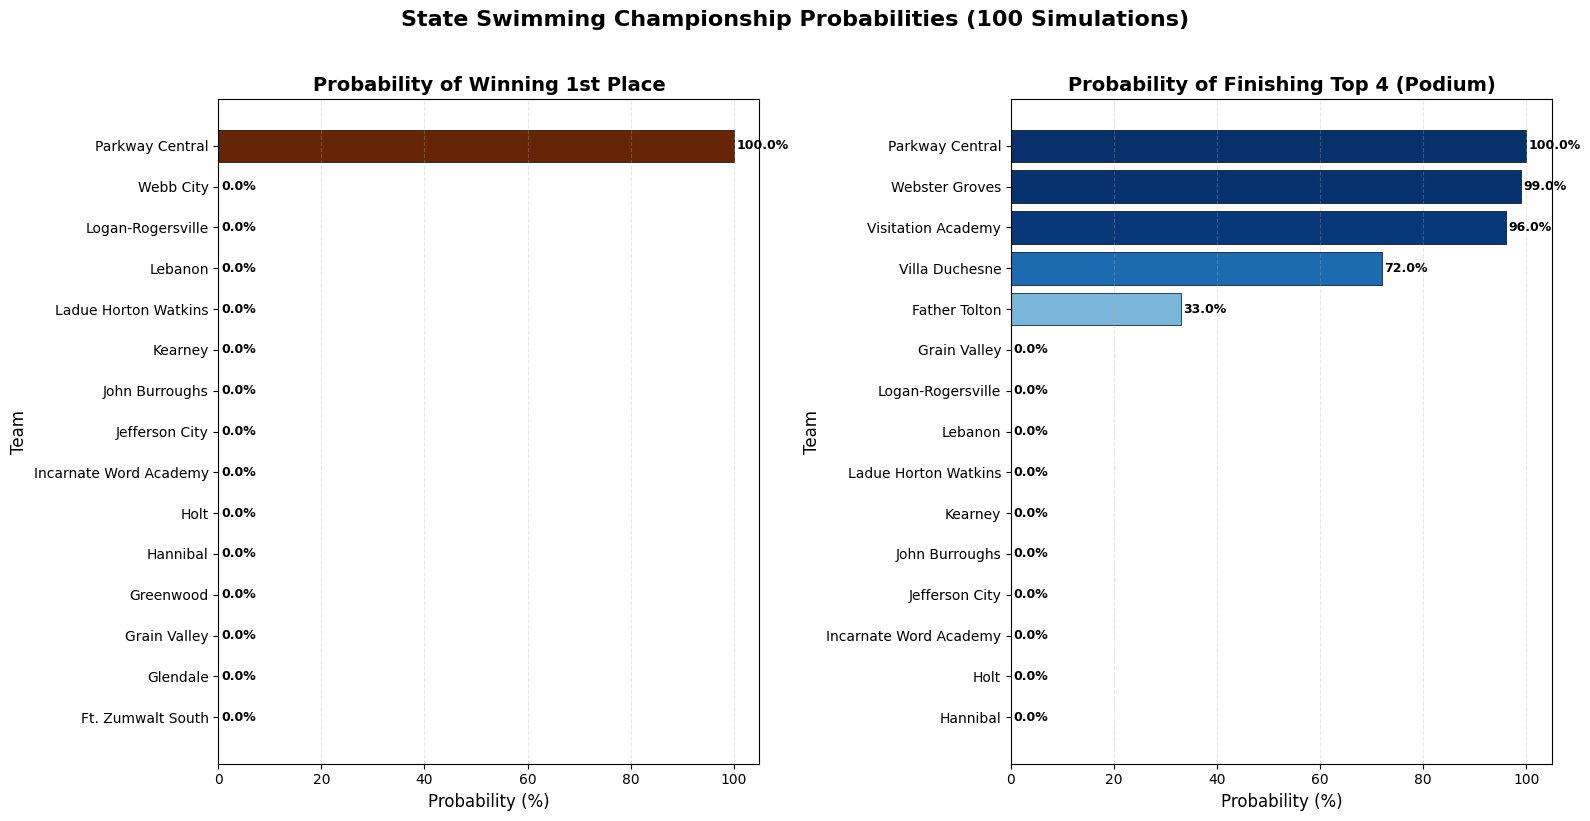

In [234]:
# Create visualization for placement probabilities
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. First Place Probabilities (Horizontal Bar Chart)
ax1 = axes[0]
first_place_sorted = prob_df.sort_values('place_1_%', ascending=True).tail(15)  # Top 15 teams

# Create gradient colors based on probability
colors_1st = plt.cm.YlOrBr((first_place_sorted['place_1_%'] / first_place_sorted['place_1_%'].max()) * 0.8 + 0.2)

bars1 = ax1.barh(range(len(first_place_sorted)), 
                 first_place_sorted['place_1_%'], 
                 color=colors_1st, 
                 edgecolor='black', 
                 linewidth=0.5)

ax1.set_yticks(range(len(first_place_sorted)))
ax1.set_yticklabels(first_place_sorted['team'])
ax1.set_title("Probability of Winning 1st Place", fontsize=14, fontweight='bold')
ax1.set_xlabel("Probability (%)", fontsize=12)
ax1.set_ylabel("Team", fontsize=12)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, prob) in enumerate(zip(bars1, first_place_sorted['place_1_%'])):
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{prob:.1f}%', va='center', fontsize=9, fontweight='bold')

# 2. Top 4 (Podium) Probabilities (Horizontal Bar Chart)
ax2 = axes[1]
podium_sorted = prob_df.sort_values('podium_%', ascending=True).tail(15)  # Top 15 teams

# Create gradient colors based on probability (blues for podium)
colors_podium = plt.cm.Blues((podium_sorted['podium_%'] / podium_sorted['podium_%'].max()) * 0.8 + 0.2)

bars2 = ax2.barh(range(len(podium_sorted)), 
                 podium_sorted['podium_%'], 
                 color=colors_podium, 
                 edgecolor='black', 
                 linewidth=0.5)

ax2.set_yticks(range(len(podium_sorted)))
ax2.set_yticklabels(podium_sorted['team'])
ax2.set_title("Probability of Finishing Top 4 (Podium)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Probability (%)", fontsize=12)
ax2.set_ylabel("Team", fontsize=12)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, prob) in enumerate(zip(bars2, podium_sorted['podium_%'])):
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{prob:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.suptitle(f"State Swimming Championship Probabilities ({total_simulations} Simulations)", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

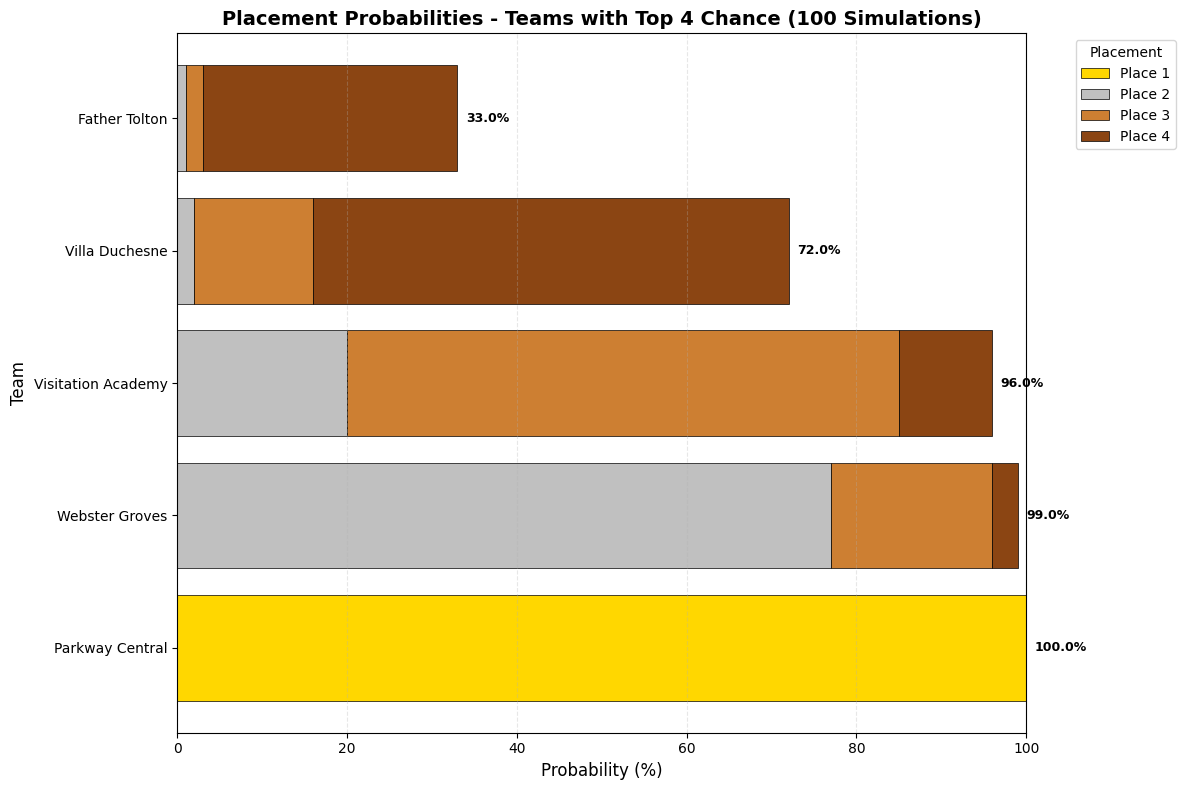

In [235]:
# Filter teams that have ANY chance of making top 4 (1st, 2nd, 3rd, or 4th)
teams_with_top4_chance = prob_df[
    (prob_df['place_1_%'] > 0) | 
    (prob_df['place_2_%'] > 0) | 
    (prob_df['place_3_%'] > 0) | 
    (prob_df['place_4_%'] > 0)
].copy()

# Take top 10 teams from those with top 4 chance (or fewer if less than 10)
top_teams = teams_with_top4_chance.head(10).copy()

fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each placement
placement_colors = {
    'place_1_%': '#FFD700',  # Gold
    'place_2_%': '#C0C0C0',  # Silver
    'place_3_%': '#CD7F32',  # Bronze
    'place_4_%': '#8B4513',  # Brown
}

# Create stacked bars
bottom = np.zeros(len(top_teams))
for placement, color in placement_colors.items():
    values = top_teams[placement].values
    ax.barh(range(len(top_teams)), values, left=bottom, 
            color=color, edgecolor='black', linewidth=0.5, 
            label=placement.replace('_%', '').replace('_', ' ').title())
    bottom += values

ax.set_yticks(range(len(top_teams)))
ax.set_yticklabels(top_teams['team'])
ax.set_xlabel("Probability (%)", fontsize=12)
ax.set_ylabel("Team", fontsize=12)
ax.set_title(f"Placement Probabilities - Teams with Top 4 Chance ({total_simulations} Simulations)", 
                fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.legend(title="Placement", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add total probability labels
for i, (team, total_prob) in enumerate(zip(top_teams['team'], top_teams['podium_%'])):
    if total_prob > 0:  # Only add label if there's any probability
        ax.text(total_prob + 1, i, f'{total_prob:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

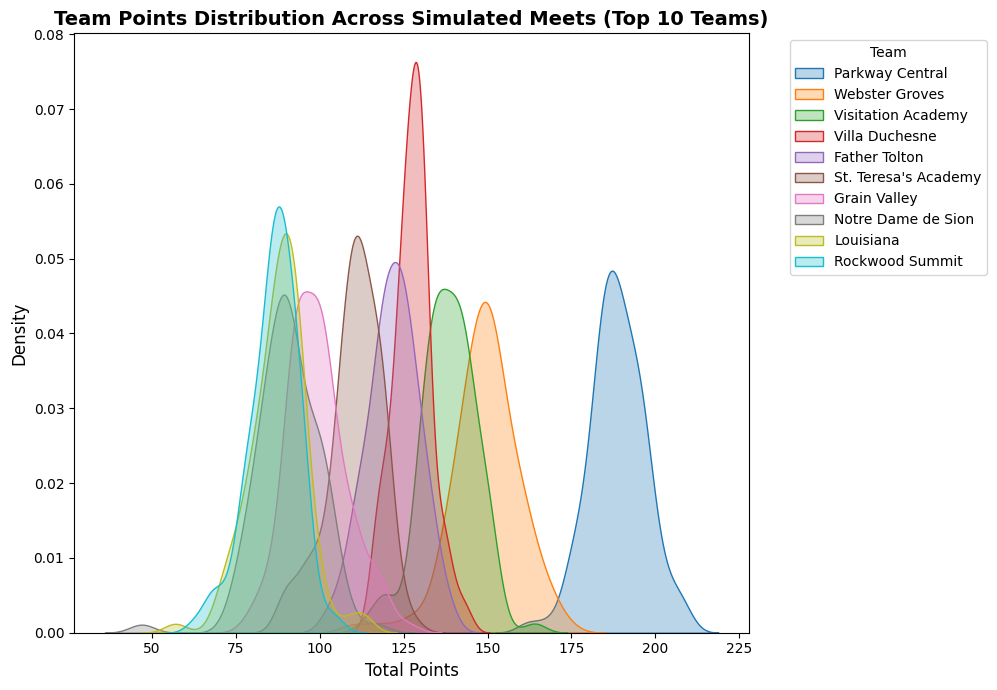

In [236]:
plt.figure(figsize=(12, 7))

# Plot top 10 teams by mean score for clarity
top_teams = team_stats.head(10).index
df_top = df_scores[df_scores['team'].isin(top_teams)]

# Create plot WITHOUT hue initially
palette = sns.color_palette('tab10', n_colors=len(top_teams))

# Plot each team individually with label
for i, team in enumerate(top_teams):
    team_data = df_top[df_top['team'] == team]
    sns.kdeplot(data=team_data, x='points', 
                fill=True, alpha=0.3, 
                color=palette[i],
                label=team)

plt.title("Team Points Distribution Across Simulated Meets (Top 10 Teams)", 
            fontsize=14, fontweight='bold')
plt.xlabel("Total Points", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right margin for legend
plt.show()

/var/folders/g9/myyy0r_n7c3fgqtzvqg5v9b00000gp/T/ipykernel_7024/4199871721.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_sorted, x='team', y='points', palette='Set2')


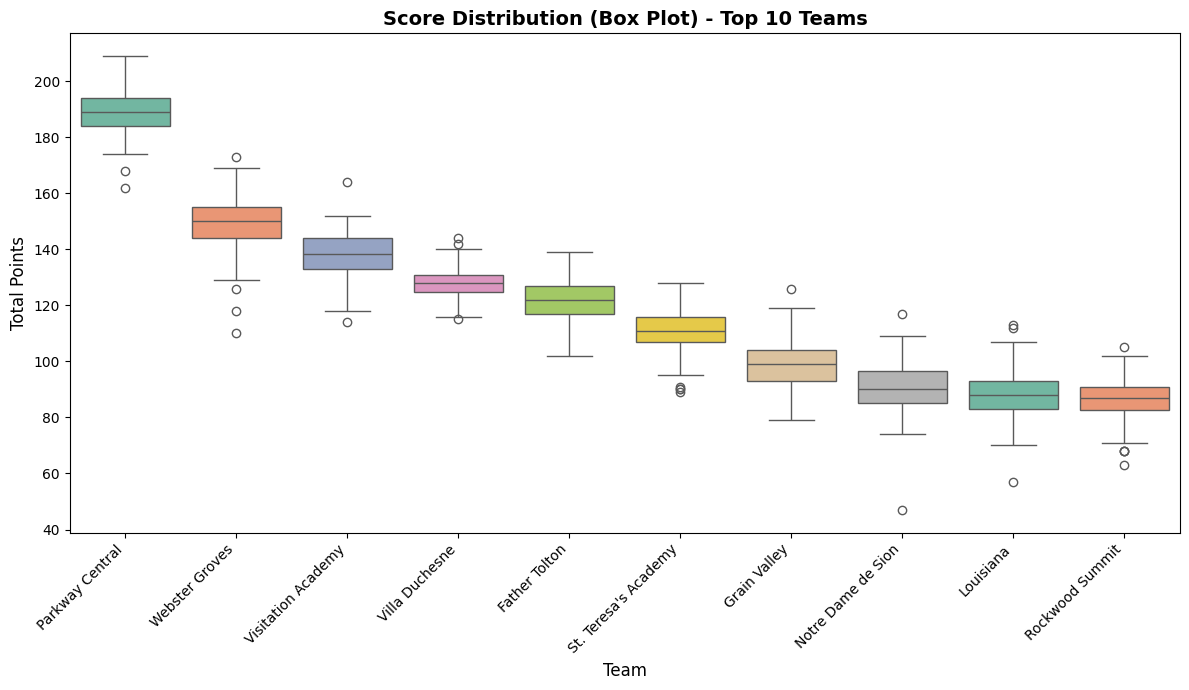

In [237]:
# Box plot showing score distributions for top teams
plt.figure(figsize=(12, 7))
top_teams_list = team_stats.head(10).index.tolist()
df_top_sorted = df_scores[df_scores['team'].isin(top_teams_list)].copy()

# Order by mean score
team_order = team_stats.head(10).index.tolist()
df_top_sorted['team'] = pd.Categorical(df_top_sorted['team'], categories=team_order, ordered=True)

sns.boxplot(data=df_top_sorted, x='team', y='points', palette='Set2')
plt.title("Score Distribution (Box Plot) - Top 10 Teams", fontsize=14, fontweight='bold')
plt.xlabel("Team", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [238]:
# Summary table combining stats and win probabilities
winners = df_scores.loc[df_scores.groupby('simulation_id')['points'].idxmax()]
win_counts = winners['team'].value_counts()
win_probs = (win_counts / len(df_scores['simulation_id'].unique()) * 100).round(2)

win_prob_df = pd.DataFrame({
    'team': win_probs.index,
    'wins': win_counts.values,
    'win_probability_%': win_probs.values
}).sort_values('win_probability_%', ascending=False)

summary = team_stats.merge(
    win_prob_df.set_index('team')[['win_probability_%', 'wins']],
    left_index=True,
    right_index=True,
    how='left'
).fillna(0)

summary = summary.sort_values('mean', ascending=False)
print("Complete Team Summary (sorted by average points):")
summary.head(15)

Complete Team Summary (sorted by average points):


,mean,std,min,max,median,q25,q75,win_probability_%,wins
team,,,,,,,,,
Parkway Central,188.6,8.2,162,209,189.0,184.0,194.0,100.0,100.0
Webster Groves,149.3,10.0,110,173,150.0,144.0,155.0,0.0,0.0
Visitation Academy,138.4,8.2,114,164,138.5,133.0,144.0,0.0,0.0
Villa Duchesne,127.6,5.6,115,144,128.0,124.8,131.0,0.0,0.0
Father Tolton,121.8,7.6,102,139,122.0,117.0,127.0,0.0,0.0
St. Teresa's Academy,110.4,7.8,89,128,111.0,107.0,116.0,0.0,0.0
Grain Valley,99.1,8.7,79,126,99.0,93.0,104.0,0.0,0.0
Notre Dame de Sion,90.6,9.3,47,117,90.0,85.0,96.5,0.0,0.0
Louisiana,87.7,8.4,57,113,88.0,83.0,93.0,0.0,0.0


In [239]:
# Podium probabilities (top 3 finish)
team_totals = df_scores.groupby(['simulation_id', 'team'])['points'].sum().reset_index()

# Rank teams within each simulation
team_totals['rank'] = team_totals.groupby('simulation_id')['points'].rank(ascending=False, method='min')
team_totals['on_podium'] = (team_totals['rank'] <= 3).astype(int)

podium_probs = team_totals.groupby('team').agg({
    'on_podium': 'mean',
    'rank': 'mean'
}).round(3)
podium_probs.columns = ['podium_probability', 'avg_rank']
podium_probs = podium_probs.sort_values('podium_probability', ascending=False)

print("Podium Finish Probabilities:")
podium_probs.head(15)


Podium Finish Probabilities:


,podium_probability,avg_rank
team,,
Parkway Central,1.00,1.00
Webster Groves,0.97,2.24
Visitation Academy,0.88,2.95
Villa Duchesne,0.16,4.09
Father Tolton,0.03,4.81
Belton,0.00,39.53
St. Charles West,0.00,39.53
Parkway North,0.00,27.04
Parkway West,0.00,17.22


In [240]:
# Modified Monte Carlo function to collect individual swimmer results
def run_monte_carlo_with_results(df, assignments, relay_assignments=None, n_sims=500):
    """
    Run Monte Carlo simulations and collect both team scores AND individual swimmer results.
    Returns: (team_scores_all dict, df_results DataFrame)
    """
    team_scores_all = defaultdict(list)
    all_results = []
    
    for i in tqdm(range(n_sims), desc="Running Monte Carlo simulations with individual results"):
        full, team_scores = simulate_one_meet(df, assignments, relay_assignments)
        
        # Add simulation ID to results
        full['simulation_id'] = i
        all_results.append(full)
        
        # Store team scores
        for team, score in team_scores.items():
            team_scores_all[team].append(score)
    
    # Combine all individual results
    df_results = pd.concat(all_results, ignore_index=True)
    
    return team_scores_all, df_results


In [241]:
# Run Monte Carlo to get individual swimmer results
# Note: This will take some time (similar to the original run_monte_carlo)

team_scores_all_with_results, df_results = run_monte_carlo_with_results(result_df, assignments, relay_assignments, n_sims=10)

print(f"Collected results from {df_results['simulation_id'].nunique()} simulations")
print(f"Total swimmer-event results: {len(df_results)}")
print(f"Individual events: {len(df_results[df_results['is_relay']==False])}")
print(f"Relay events: {len(df_results[df_results['is_relay']==True])}")
print(f"\nColumns in df_results: {df_results.columns.tolist()}")
print(f"\nFirst few rows:")
df_results.head(10)


Running Monte Carlo simulations with individual results: 100%|██████████| 10/10 [00:00<00:00, 16.54it/s]

Collected results from 10 simulations
Total swimmer-event results: 2160
Individual events: 800
Relay events: 1360

Columns in df_results: ['name', 'team', 'event', 'time', 'state', 'is_relay', 'place', 'points', 'simulation_id']

First few rows:


,name,team,event,time,state,is_relay,place,points,simulation_id
0,Jane Hill,Villa Duchesne,100 Back,61.598838,Average,False,1,20,0
1,Reece Gould,Savannah,100 Back,63.115898,Bad,False,2,17,0
2,Isabell Coffey,Monett,100 Back,63.132364,Average,False,3,16,0
3,Lucia Fox,Parkway West,100 Back,63.285411,Bad,False,4,15,0
4,Alicia Williams,John Burroughs,100 Breast,73.384932,Average,False,1,20,0
5,Kylie Montgomery,Webster Groves,100 Breast,73.459714,Average,False,2,17,0
6,Kelly Frank,Notre Dame de Sion,100 Breast,73.470079,Average,False,3,16,0
7,Olivia Johnson,Hannibal,100 Breast,74.691402,Good,False,4,15,0
8,Emelia Rosebaugh,Monett,100 Breast,74.700879,Bad,False,5,14,0
9,Sophia Hall,St. Pius X (Kansas City),100 Fly,51.246098,Bad,False,1,20,0


In [242]:
# show simple mean scores
res = sorted({team: float(np.mean(scores)) 
        for team,scores in team_scores_all.items()}.items(), 
    key=lambda item: item[1], 
    reverse=True)[:10]

print("avg points per school across all simulations")
print("=" * 45)
print(f"{'Rank':<5} {'School':<25} {'Avg Points':>12}")
print("-" * 45)
for rank, (school, points) in enumerate(res, 1):
    print(f"{rank:>2}.  {school:25} {points:>6.1f} points")

avg points per school across all simulations
Rank  School                      Avg Points
---------------------------------------------
 1.  Parkway Central            188.6 points
 2.  Webster Groves             149.3 points
 3.  Visitation Academy         138.3 points
 4.  Villa Duchesne             127.6 points
 5.  Father Tolton              121.8 points
 6.  St. Teresa's Academy       110.4 points
 7.  Grain Valley                99.1 points
 8.  Notre Dame de Sion          90.5 points
 9.  Louisiana                   87.7 points
10.  Rockwood Summit             86.2 points


/var/folders/g9/myyy0r_n7c3fgqtzvqg5v9b00000gp/T/ipykernel_7024/2476439209.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


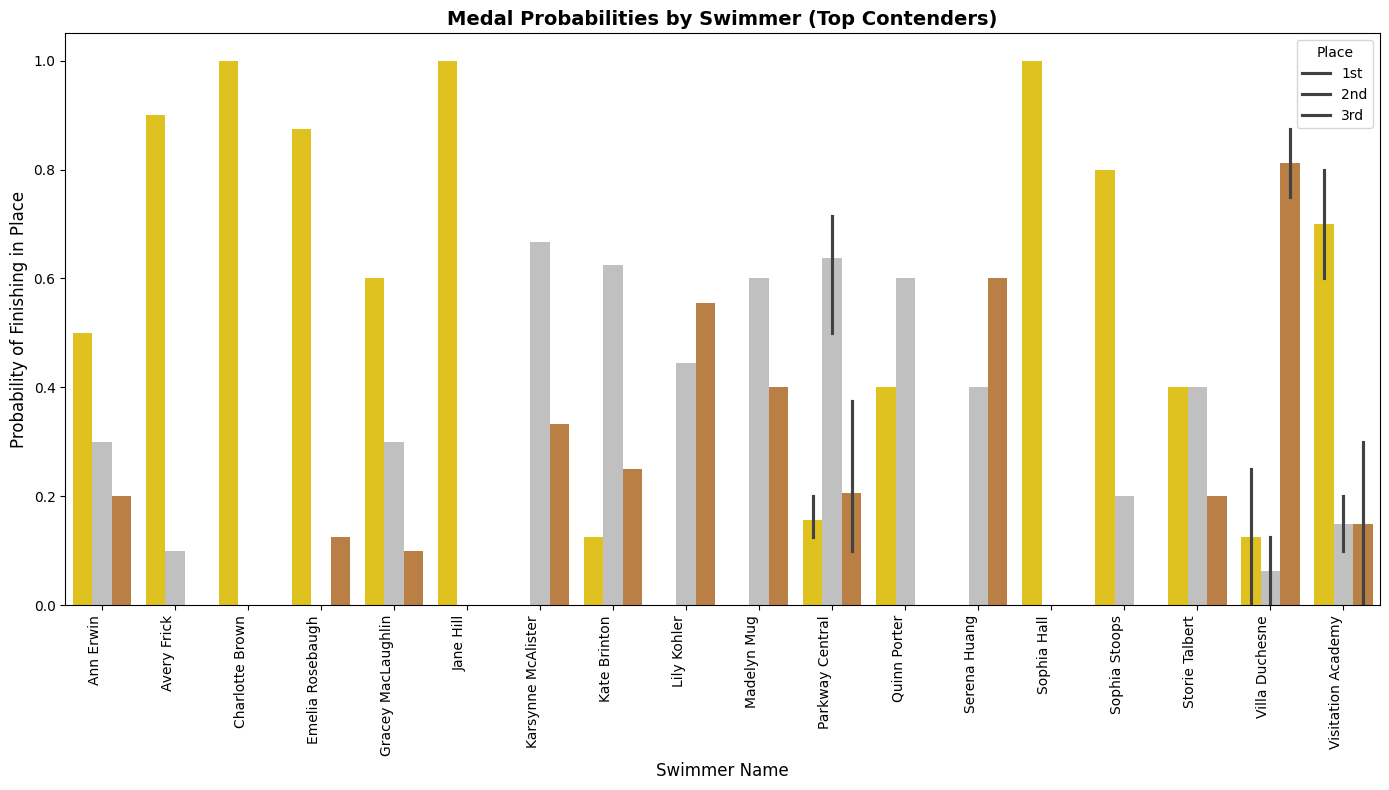

In [243]:
# Calculate medal probabilities (top 3 places)
# Note: 'name' is the column name from simulate_one_meet, not 'swimmer_name'
medal_probs = (
    df_results[df_results['place'] <= 3]
    .groupby(['name', 'event', 'place'])
    .size()
    .reset_index(name='count')
    .groupby(['name', 'event'])
    .apply(lambda x: pd.Series({
        'place_1': (x[x['place'] == 1]['count'].sum() / x['count'].sum()) if (x['place'] == 1).any() else 0,
        'place_2': (x[x['place'] == 2]['count'].sum() / x['count'].sum()) if (x['place'] == 2).any() else 0,
        'place_3': (x[x['place'] == 3]['count'].sum() / x['count'].sum()) if (x['place'] == 3).any() else 0,
        'total_podium': x['count'].sum() / df_results['simulation_id'].nunique()
    }))
    .reset_index()
)

# Melt to long format for easier plotting
medal_probs_long = medal_probs.melt(
    id_vars=['name', 'event'],
    value_vars=['place_1', 'place_2', 'place_3'],
    var_name='place',
    value_name='probability'
)
medal_probs_long['place'] = medal_probs_long['place'].str.replace('place_', '').astype(int)

# Filter to swimmers with meaningful podium probabilities (at least 1% in any simulation)
top_medal_contenders = medal_probs[medal_probs['total_podium'] > 0.01].sort_values('total_podium', ascending=False)
top_names = top_medal_contenders['name'].head(20).unique()

medal_probs_filtered = medal_probs_long[medal_probs_long['name'].isin(top_names)]

plt.figure(figsize=(14, 8))
sns.barplot(data=medal_probs_filtered, x='name', y='probability', hue='place', palette={1: 'gold', 2: 'silver', 3: '#CD7F32'})
plt.title("Medal Probabilities by Swimmer (Top Contenders)", fontsize=14, fontweight='bold')
plt.xticks(rotation=90, ha='right')
plt.ylabel("Probability of Finishing in Place", fontsize=12)
plt.xlabel("Swimmer Name", fontsize=12)
plt.legend(title='Place', labels=['1st', '2nd', '3rd'])
plt.tight_layout()
plt.show()

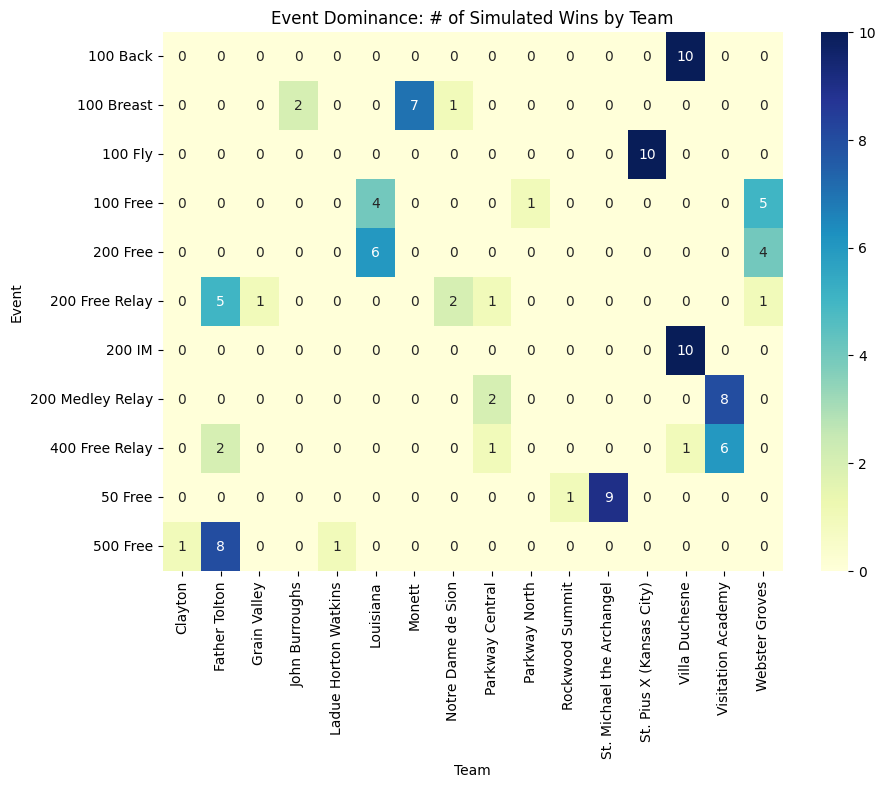

In [244]:
event_strength = (
    df_results[df_results['place'] == 1]
    .groupby(['event', 'team'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10,7))
sns.heatmap(event_strength, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Event Dominance: # of Simulated Wins by Team")
plt.xlabel("Team")
plt.ylabel("Event")
plt.show()

## Relay Probabilities Analysis

Relays are scored with DOUBLE points, so they have a significant impact on team scores. Let's analyze relay win probabilities and medal probabilities.


In [245]:
# Relay win probabilities (which team wins each relay event most often)
# Check if is_relay column exists, if not infer from event names
if 'is_relay' in df_results.columns:
    relay_results = df_results[df_results['is_relay'] == True].copy()
else:
    # Infer relays from event names containing "Relay"
    print("Note: 'is_relay' column not found. Inferring relays from event names...")
    df_results['is_relay'] = df_results['event'].str.contains('Relay', case=False, na=False)
    relay_results = df_results[df_results['is_relay'] == True].copy()

if len(relay_results) == 0:
    print("⚠️ No relay results found. Please re-run the Monte Carlo simulation after updating the code.")
    print("Relay events should now be included in result_df with is_relay=True")
else:
    relay_win_probs = (
        relay_results[relay_results['place'] == 1]
        .groupby(['event', 'team'])
        .size()
        .reset_index(name='wins')
        .groupby('event')
        .apply(lambda x: x.assign(win_probability=x['wins'] / x['wins'].sum() * 100))
        .reset_index(drop=True)
        .sort_values(['event', 'win_probability'], ascending=[True, False])
    )

    print("Relay Win Probabilities by Event and Team:")
    print(f"Total simulations: {df_results['simulation_id'].nunique()}")
    relay_win_probs.head(20)


Relay Win Probabilities by Event and Team:
Total simulations: 10


/var/folders/g9/myyy0r_n7c3fgqtzvqg5v9b00000gp/T/ipykernel_7024/3678600167.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(win_probability=x['wins'] / x['wins'].sum() * 100))


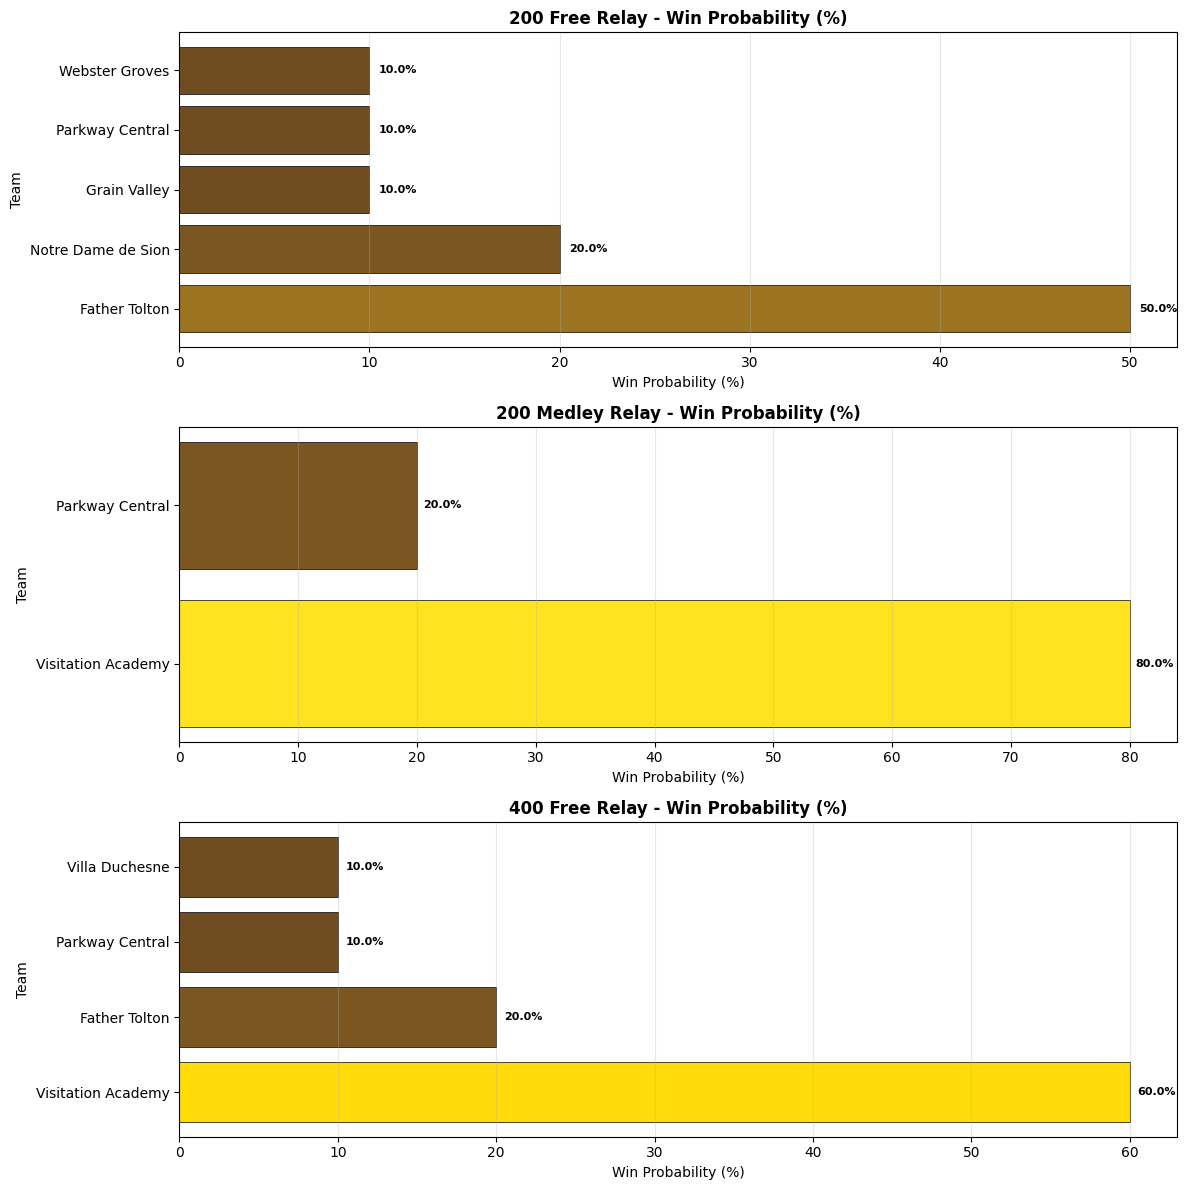

In [246]:
# Visualize relay win probabilities
relay_events = relay_results['event'].unique()
fig, axes = plt.subplots(len(relay_events), 1, figsize=(12, 4*len(relay_events)))
if len(relay_events) == 1:
    axes = [axes]

for idx, event in enumerate(relay_events):
    event_data = relay_win_probs[relay_win_probs['event'] == event].head(10)
    if len(event_data) > 0:
        # Create gradient color from brown (low prob) to gold (high prob)
        probs = event_data['win_probability']
        
        # Normalize probabilities for color mapping (0-1 range)
        norm_probs = probs / 100
        
        # Create color gradient: brown to gold
        colors = []
        for prob in norm_probs:
            if prob > 0.5:  # More likely to win (gold to yellow)
                # Interpolate from goldenrod to gold based on probability
                weight = min(1.0, (prob - 0.5) * 2)  # Scale from 0.5-1 to 0-1
                r = 255
                g = 215 + (20 * weight)  # From 215 to 235
                b = 0 + (50 * weight)    # From 0 to 50
                colors.append((r/255, g/255, b/255))
            else:  # Less likely to win (brown shades)
                weight = prob * 2  # Scale 0-0.5 to 0-1
                r = 101 + (54 * weight)   # From 101 to 155
                g = 67 + (48 * weight)    # From 67 to 115
                b = 33                    # Brown stays constant
                colors.append((r/255, g/255, b/255))
        
        axes[idx].barh(event_data['team'], probs, color=colors, edgecolor='black', linewidth=0.5)
        axes[idx].set_title(f"{event} - Win Probability (%)", fontsize=12, fontweight='bold')
        axes[idx].set_xlabel("Win Probability (%)", fontsize=10)
        axes[idx].set_ylabel("Team", fontsize=10)
        axes[idx].grid(axis='x', alpha=0.3)
        
        # Add probability labels on bars
        for i, (bar, prob) in enumerate(zip(axes[idx].patches, probs)):
            width = bar.get_width()
            axes[idx].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                          f'{prob:.1f}%', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [247]:
# Relay medal probabilities (top 3 places)
if len(relay_results) > 0:
    relay_medal_probs = (
        relay_results[relay_results['place'] <= 3]
        .groupby(['event', 'team', 'place'])
        .size()
        .reset_index(name='count')
        .groupby(['event', 'team'])
        .apply(lambda x: pd.Series({
            'place_1': (x[x['place'] == 1]['count'].sum() / x['count'].sum()) if (x['place'] == 1).any() else 0,
            'place_2': (x[x['place'] == 2]['count'].sum() / x['count'].sum()) if (x['place'] == 2).any() else 0,
            'place_3': (x[x['place'] == 3]['count'].sum() / x['count'].sum()) if (x['place'] == 3).any() else 0,
            'total_podium': x['count'].sum() / df_results['simulation_id'].nunique()
        }))
        .reset_index()
    )

    # Melt to long format
    relay_medal_probs_long = relay_medal_probs.melt(
        id_vars=['event', 'team'],
        value_vars=['place_1', 'place_2', 'place_3'],
        var_name='place',
        value_name='probability'
    )
    relay_medal_probs_long['place'] = relay_medal_probs_long['place'].str.replace('place_', '').astype(int)

    # Filter to top contenders (at least 5% podium probability)
    top_relay_contenders = relay_medal_probs[relay_medal_probs['total_podium'] > 0.05].sort_values('total_podium', ascending=False)

    print("Relay Medal Probabilities (Top Contenders):")
    print(f"Showing teams with at least 5% podium probability")
    top_relay_contenders.head(20)
else:
    print("No relay results found. Please re-run the Monte Carlo simulation.")


Relay Medal Probabilities (Top Contenders):
Showing teams with at least 5% podium probability


/var/folders/g9/myyy0r_n7c3fgqtzvqg5v9b00000gp/T/ipykernel_7024/3221821452.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


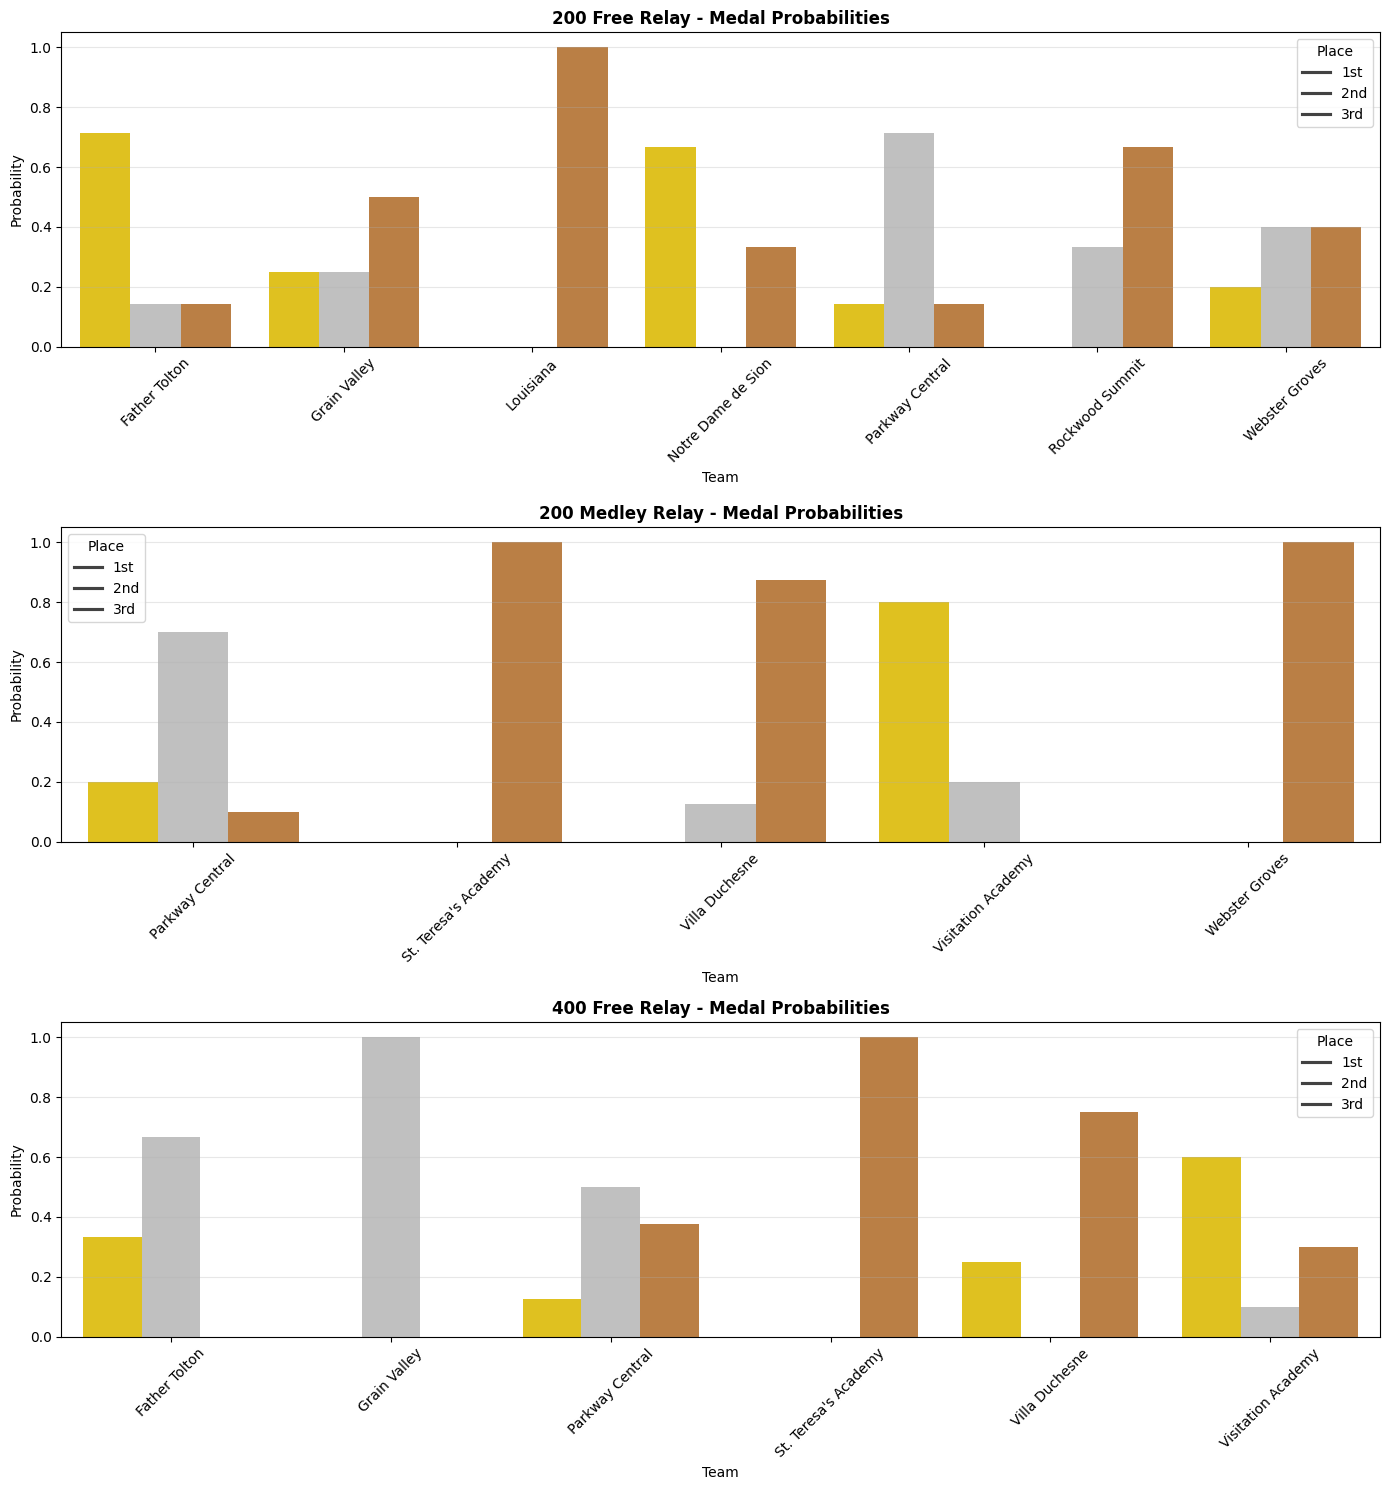

In [248]:
# Visualize relay medal probabilities
if len(relay_results) > 0 and 'relay_medal_probs_long' in locals() and 'top_relay_contenders' in locals():
    relay_events = relay_results['event'].unique()
    if len(relay_events) > 0:
        fig, axes = plt.subplots(len(relay_events), 1, figsize=(14, 5*len(relay_events)))
        if len(relay_events) == 1:
            axes = [axes]

        for idx, event in enumerate(relay_events):
            event_contenders = top_relay_contenders[top_relay_contenders['event'] == event]['team'].head(10)
            if len(event_contenders) > 0:
                event_data = relay_medal_probs_long[
                    (relay_medal_probs_long['event'] == event) & 
                    (relay_medal_probs_long['team'].isin(event_contenders))
                ]
                
                if len(event_data) > 0:
                    sns.barplot(data=event_data, x='team', y='probability', hue='place', 
                               palette={1: 'gold', 2: 'silver', 3: '#CD7F32'}, ax=axes[idx])
                    axes[idx].set_title(f"{event} - Medal Probabilities", fontsize=12, fontweight='bold')
                    axes[idx].set_xlabel("Team", fontsize=10)
                    axes[idx].set_ylabel("Probability", fontsize=10)
                    axes[idx].tick_params(axis='x', rotation=45)
                    axes[idx].legend(title='Place', labels=['1st', '2nd', '3rd'])
                    axes[idx].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("No relay events found to visualize")
else:
    print("No relay medal data available. re-run the Monte Carlo simulation.")


In [249]:
individual_points = (
    df_results[df_results['is_relay'] == False]
    .groupby(['simulation_id', 'team'])['points']
    .sum()
    .reset_index()
    .rename(columns={'points': 'individual_points'})
)

# Relay points by team
relay_points = (
    relay_results.groupby(['simulation_id', 'team'])['points']
    .sum()
    .reset_index()
    .rename(columns={'points': 'relay_points'})
)

# Combine individual and relay points
total_points = individual_points.merge(
    relay_points,
    on=['simulation_id', 'team'],
    how='outer'
).fillna(0)

total_points['total_points'] = total_points['individual_points'] + total_points['relay_points']

# Summary statistics by team
team_breakdown = (
    total_points.groupby('team')
    .agg({
        'individual_points': ['mean', 'std'],
        'relay_points': ['mean', 'std'],
        'total_points': ['mean', 'std', 'min', 'max']
    })
    .round(1)
)

# Flatten column names
team_breakdown.columns = [
    'avg_individual_pts', 'std_individual_pts',
    'avg_relay_pts', 'std_relay_pts',
    'avg_total_pts', 'std_total_pts', 'min_total_pts', 'max_total_pts'
]

team_breakdown = team_breakdown.sort_values('avg_total_pts', ascending=False)

In [250]:
print("Team Points Breakdown: Individual Events + Relays")
print("\nTop 15 teams by average total points:")
team_breakdown.head(15)

Team Points Breakdown: Individual Events + Relays

Top 15 teams by average total points:


,avg_individual_pts,std_individual_pts,avg_relay_pts,std_relay_pts,avg_total_pts,std_total_pts,min_total_pts,max_total_pts
team,,,,,,,,
Parkway Central,89.3,4.6,99.0,3.2,188.3,5.7,180.0,197.0
Webster Groves,62.2,2.3,87.6,4.9,149.8,4.7,141.0,155.0
Visitation Academy,49.4,3.7,91.6,8.2,141.0,9.2,123.0,155.0
Villa Duchesne,63.1,3.4,62.2,4.5,125.3,4.1,118.0,133.0
Father Tolton,55.7,2.1,68.6,7.5,124.3,7.3,114.0,136.0
St. Teresa's Academy,38.2,3.6,70.2,9.8,108.4,10.0,83.0,117.0
Notre Dame de Sion,37.4,4.6,60.2,9.9,97.6,12.5,79.0,115.0
Grain Valley,35.6,3.7,60.6,11.0,96.2,11.2,80.0,118.0
Rockwood Summit,35.1,3.3,51.0,6.4,86.1,6.0,70.0,92.0


In [251]:
team_breakdown['relay_contribution_%'] = (
    (team_breakdown['avg_relay_pts'] / team_breakdown['avg_total_pts'] * 100).round(1)
)
print("\nRelay contribution as percentage of total points:")
team_breakdown[['avg_individual_pts', 'avg_relay_pts', 'avg_total_pts', 'relay_contribution_%']].head(15)


Relay contribution as percentage of total points:


,avg_individual_pts,avg_relay_pts,avg_total_pts,relay_contribution_%
team,,,,
Parkway Central,89.3,99.0,188.3,52.6
Webster Groves,62.2,87.6,149.8,58.5
Visitation Academy,49.4,91.6,141.0,65.0
Villa Duchesne,63.1,62.2,125.3,49.6
Father Tolton,55.7,68.6,124.3,55.2
St. Teresa's Academy,38.2,70.2,108.4,64.8
Notre Dame de Sion,37.4,60.2,97.6,61.7
Grain Valley,35.6,60.6,96.2,63.0
Rockwood Summit,35.1,51.0,86.1,59.2
